# kanecounty - All products
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 51 # kanecounty
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(818, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            818 non-null    int64  
 1   dimCustomerMasterId     818 non-null    int64  
 2   customerNumber          818 non-null    object 
 3   year                    818 non-null    int64  
 4   productGrouping         818 non-null    object 
 5   totalSpent              818 non-null    float64
 6   recentDate              818 non-null    object 
 7   attendancePercent       818 non-null    float64
 8   renewedBeforeDays       818 non-null    int64  
 9   isBuyer                 818 non-null    object 
 10  source_tenure           818 non-null    int64  
 11  tenure                  818 non-null    int64  
 12  distToVenue             818 non-null    float64
 13  totalGames              818 non-null    int64  
 14  recency                 818 non-null    in

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
        "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "distToVenue",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "NumberofGamesPerSeason",
        "is_Lockdown"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (484, 15)
Unseen Data For Predictions: (85, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
     "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "distToVenue",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "NumberofGamesPerSeason",
        "is_Lockdown"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7326,0.7023,0.8783,0.7720,0.8210,0.2970,0.3101,0.2440
lr,Logistic Regression,0.7276,0.6825,0.9372,0.7438,0.8284,0.2062,0.2467,0.3520


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6429,0.6393,0.7586,0.7333,0.7458,0.1463,0.1466
1,0.7805,0.7874,0.8966,0.8125,0.8525,0.4279,0.4359
2,0.8049,0.7644,0.9655,0.8000,0.8750,0.4478,0.4920
3,0.7805,0.8046,0.8621,0.8333,0.8475,0.4566,0.4574
4,0.6585,0.5833,0.8621,0.7143,0.7813,0.0337,0.0370
5,0.8293,0.8477,0.9310,0.8438,0.8852,0.5550,0.5654
6,0.7317,0.6121,0.8966,0.7647,0.8254,0.2619,0.2780
7,0.7561,0.7759,0.8966,0.7879,0.8387,0.3471,0.3596
8,0.7317,0.7500,0.9286,0.7429,0.8254,0.2761,0.3111
9,0.6098,0.4588,0.7857,0.6875,0.7333,0.0180,0.0185


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(249, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
569,51,325455608,10708034,2021,Package,536.4,2021-08-07,0.638889,151,TRUE,...,0,0,0.0,1,132,0,0,1,0.1798,0.8202
570,51,325455953,11082921,2021,Package,149.0,2021-07-23,0.400000,102,TRUE,...,0,0,0.0,1,132,0,0,0,0.7710,0.2290
571,51,325455971,4001332,2021,Package,149.0,2021-07-06,0.800000,75,TRUE,...,0,0,0.0,1,132,0,1,0,0.9564,0.0436
572,51,325456217,4019116,2021,Package,119.2,2021-09-06,0.285714,103,TRUE,...,0,0,0.0,1,132,0,0,0,0.8052,0.1948
573,51,325456274,10387141,2021,Package,269.0,2021-09-05,0.850000,84,TRUE,...,0,0,0.0,1,132,0,1,1,0.0690,0.9310


In [11]:
new_predictions["Label"].value_counts()

1    139
0    110
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       103
(-0.001, 0.2]     58
(0.2, 0.4]        33
(0.4, 0.6]        29
(0.6, 0.8]        26
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

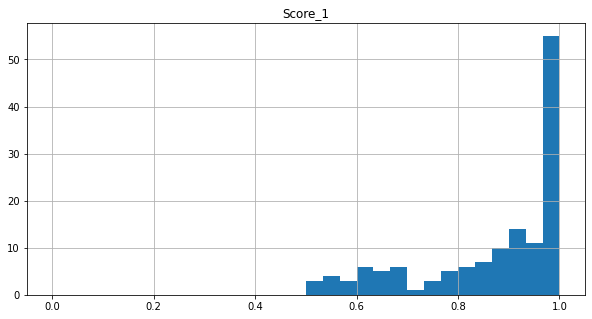

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

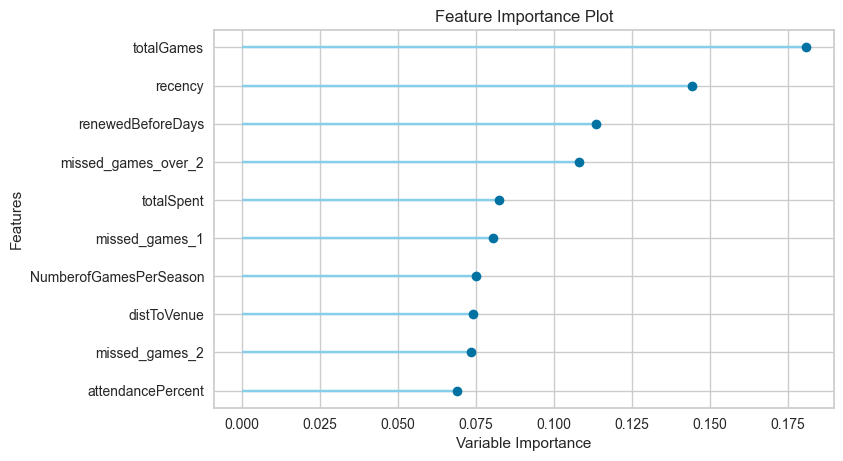

In [14]:
plot_model(best_model, plot='feature')

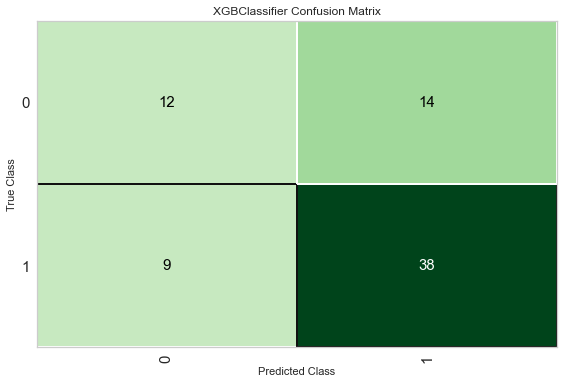

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?